<a href="https://colab.research.google.com/github/vinits7/ML-Projects/blob/main/ResumeParserUsingSpacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Vinit Shah**

**Building a Resume Parser Using NLP(Spacy) and Machine Learning**

Introduction:

In this project, we are going to use spacy for entity recognition on 200 Resume and experiment around various NLP tools for text analysis. The main purpose of this project is to help recruiters go throwing hundreds of applications within a few minutes. We have also added skills match feature so that hiring managers can follow a metric that will help them to decide whether they should move to the interview stage or not. We will be using two datasets; the first contains resume texts and the second contains skills that we will use to create an entity ruler.

In [1]:
!pip install spacy
!pip install gensim
!pip install pyLDAvis
!pip install wordcloud
!pip install plotly
!pip install jsonlines
!python -m spacy download en_core_web_lg

#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

#gensim
#done afterwards; the newer update does not work well in colab

#Visualization
from spacy import displacy
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines



#warning
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-06-18 09:52:59.935672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 09:53:02.064258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

livecareer.com resume Dataset

A collection of 2400+ Resume Examples taken from livecareer.com for categorizing a given resume into any of the labels defined in the dataset: Resume Dataset.

Inside the CSV

ID: Unique identifier and file name for the respective pdf.
Resume_str : Contains the resume text only in string format.
Resume_html : Contains the resume data in html format as present while web scrapping.
Category : Category of the job the resume was used to apply.

Present categories

HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, Healthcare, Fitness, Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, Finance, Apparel, Engineering, Accountant, Construction, Public-Relations, Banking, Arts, Aviation

Loading

In this section, we are going to load the spaCy model, Resume Dataset, and Jobzilla skills dataset directly into the entity ruler.

Resume Dataset

Using Pandas read_csv to read dataset containing text data about Resume.

we are going to randomized Job categories so that 200 samples contain various job categories instead of one.

we are going to limit our number of samples to 200 as processing 2400+ takes time.

In [2]:
# Loading data

df = pd.read_csv('/content/Resume.csv')
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[
    0:200,
]
df.head()


,ID,Resume_str,Resume_html,Category
1568,20880935,SPECIAL FINANCE MANAGER Sum...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE
314,10641230,IT MANAGEMENT Career Overvi...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
152,28326441,FREELANCE DESIGNER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
1523,74849878,FINANCE ASSISTANT Professional ...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE
1091,24610685,SALES ENGINEER Summary I...,"<div class=""fontsize fontface vmargins hmargin...",SALES


Loading spaCy model

You can download spaCy model using python -m spacy en_core_web_lg

Then load spacy model into nlp.

In [3]:
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "jz_skill_patterns.jsonl"

Entity Ruler

To create an entity ruler we need to add a pipeline and then load the .jsonl file containing skills into ruler. As you can see we have successfully added a new pipeline entity_ruler. Entity ruler helps us add additional rules to highlight various categories within the text, such as skills and job description in our case.

In [4]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names


['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

Skills

We will create two python functions to extract all the skills within a resume and create an array containing all the skills. Later we are going to apply this function to our dataset and create a new feature called skill. This will help us visualize trends and patterns within the dataset.

get_skills is going to extract skills from a single text.

unique_skills will remove duplicates.

In [5]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

Cleaning Resume Text

We are going to use nltk library to clean our dataset in a few steps:

We are going to use regex to remove hyperlinks, special characters, or punctuations.

Lowering text

Splitting text into array based on space

Lemmatizing text to its base form for normalizations

Removing English stopwords

Appending the results into an array.

In [6]:
#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Applying functions

In this section, we are going to apply all the functions we have created previously

creating Clean_Resume columns and adding cleaning Resume data.

creating skills columns, lowering text, and applying the get_skills function.

removing duplicates from skills columns.

As you can see below that we have cleaned the resume and skills columns.

In [7]:
!pip install requests
from requests import get

data["Clean_Resume"] = clean
data.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,ID,Resume_str,Resume_html,Category,Clean_Resume
1568,20880935,SPECIAL FINANCE MANAGER Sum...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE,special finance manager summary seeking positi...
314,10641230,IT MANAGEMENT Career Overvi...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,management career overview detail oriented pro...
152,28326441,FREELANCE DESIGNER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,freelance designer summary multi disciplinary ...
1523,74849878,FINANCE ASSISTANT Professional ...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE,finance assistant professional summary college...
1091,24610685,SALES ENGINEER Summary I...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale engineer summary currently looking advanc...


Visualization

Now that we have everything we want, we are going to visualize Job distributions and skill distributions.

Jobs Distribution

As we can see our random 200 samples contain a variety of job categories. Accountants, Business development, and Advocates are the top categories.

In [8]:
fig = px.histogram(
    data, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

Skills

In this part, we are going to use the Deepnote input cell to create category variables and then visualize the distribution of skills based on selected Job Descriptions.

First, we need to create variables from the dataset using unique() and then add the ALL category so that we can also visualize the overall skills trend in the dataset. lastly, we are going to use input cells and import categories from variables, as shown below.



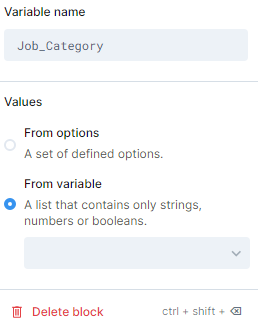

As we can observe INFORMATION-TECHNOLOGY job category's skills distributions.

Top Skills

Software

Support

Business

If you are looking to improve your chance of getting hired by a software company try focusing on software engineering, Support, and Business skills.

In [9]:
Job_cat = data["Category"].unique()
Job_cat = np.append(Job_cat, "ALL")

In [10]:
Job_Category = "INFORMATION-TECHNOLOGY"

Most used words

In this part, we are going to display the most used words in the Resume filter by job category. In Information technology, the most words used are system, network, and database. We can also discover more patterns by exploring the word cloud below.



Text(0.5, 1.0, "Most Used Words in ['FINANCE' 'INFORMATION-TECHNOLOGY' 'DESIGNER' 'SALES' 'ADVOCATE'\n 'APPAREL' 'DIGITAL-MEDIA' 'TEACHER' 'ENGINEERING' 'HEALTHCARE' 'FITNESS'\n 'CHEF' 'HR' 'CONSTRUCTION' 'BANKING' 'AGRICULTURE' 'PUBLIC-RELATIONS'\n 'AVIATION' 'CONSULTANT' 'ARTS' 'BUSINESS-DEVELOPMENT' 'AUTOMOBILE'\n 'ACCOUNTANT' 'ALL'] Resume")

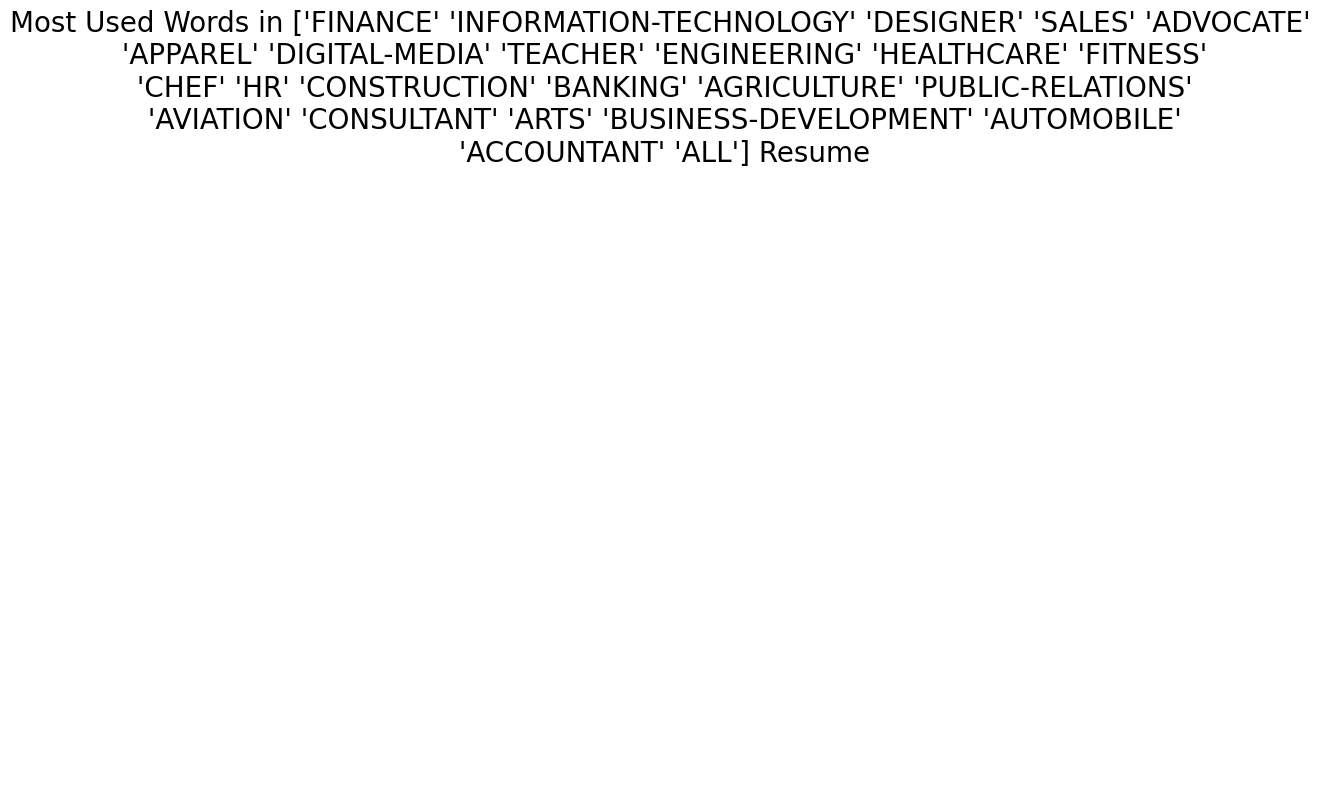

In [11]:
text = ""


plt.figure(figsize=(8, 8))

x, y = np.ogrid[:800, :800]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)


plt.axis("off")

plt.title(f"Most Used Words in {Job_cat} Resume", fontsize=20)

Entity Recognition

We can also display various entities within our raw text by using spaCy displacy.render. I am in love with this function as it is an amazing way to look at your entire document and discover SKILL or GEP within your Resume.

In [12]:
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

Dependency Parsing

We can also visualize dependencies by just changing style to dep as shown below. We have also limited words to 10 which includes space too. Limiting the words will make it visualize the small chunk of data and if you want to see the dependency, you can remove the filter.

In [13]:
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

Custom Entity Recognition

In our case, we have added a new entity called SKILL and is displayed in gray color. I was not impressed by colors and I also wanted to add another entity called Job Description so I started experimenting with various parameters within `displace.

Adding Job-Category into entity ruler.

Adding custom colors to all categories.

Adding gradient colors to SKILL and Job-Category

You can see the result below as the new highlighted texts look beautiful.

In [14]:
patterns = df.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label": "Job-Category", "pattern": a}])

In [15]:
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

Your Resume Anlaysis

In this part, I am allowing users to copy&paste their resumes and see the results.

As we can see my I have added my Resume and the results are amazing. The model has successfully highlighted all the skills.

In [16]:
input_resume = "Vinit Shah Data Scientist I am a certified data scientist professional, who loves building machine learning models and blogs about the latest AI technologies. I am currently testing AI Products at StayVista, which later gets approved for human trials. vinit@gmail.com +918823453343 Mumbai, India vinit.me WORK EXPERIENCE Data Scientist SSD Innovation and Testing Center - 04/2021 - Present, Mumbai. Redesigned data of engineers that were mostly scattered and unavailable. Designed dashboard and data analysis report to help higher management make better decisions. Accessibility of key information has created a new culture of making data-driven decisions. Contact: Rakesh - bestie@gmail.com Data Scientist Freelancing/Kaggle 11/2020 - Present, Mumbai. Engineered a healthcare system. Used machine learning to detect some of the common decisions. The project has paved the way for others to use new techniques to get better results. Participated in Kaggle machine learning competitions. Learned new techniques to get a better score and finally got to 1 percent rank. Researcher / Event Organizer CREDIT 02/2017 - 07/2017, Kuala Lumpur, Malaysia Marketing for newly build research lab. Organized technical events and successfully invited the multiple company's CEO for talks. Reduced the gap between industries and educational institutes. Research on new development in the IoT sector. Created research proposal for funding. Investigated the new communication protocol for IoT devices. Contact: Dr. Tan Chye Cheah - dr.chyecheah.t@apu.edu.my EDUCATION MSc in Technology Management Staffordshire University 11/2015 - 04/2017, Postgraduate with Distinction Challenges in Implementing IoT-enabled Smart cities in Malaysia. Bachelors Electronics and Telecommunication Engineering DJ Sanghvi College of Engineering, Mumbai 2020- - 2024, CGPA: 9 Networking Satellite communications Programming/ Matlab Telecommunication Engineering SKILLS Designing Leadership Media/Marketing R/Python SQL Tableau NLP Data Analysis Machine learning Deep learning Webapp/Cloud Feature Engineering Ensembling Time Series Technology Management ACHIEVEMENTS 98th Hungry Geese Simulation Competition (08/2021) 2nd in Covid-19 vaccinations around the world (07/2021) 8th in Automatic Speech Recognition in WOLOF (06/2021) Top 10 in WiDS Datathon. (03/2021) 40th / 622 in MagNet: Model the Geomagnetic Field Hosted by NOAA (02/2021) 18th in Rock, Paper, Scissors/Designing AI Agent Competition. (02/2021) PROJECTS Goodreads Profile Analysis WebApp (09/2021) Data Analysis Web Scraping XLM Interactive Visualization Contributed in orchest.io (08/2021) Testing and Debuging Technical Article Proposing new was to Improve ML pipelines World Vaccine Update System (06/2021) Used sqlite3 for database Automated system for daily update the Kaggle DB and Analysis Interactive dashboard mRNA-Vaccine-Degradation-Prediction (06/2021) Explore our dataset and then preprocessed sequence, structure, and predicted loop type features Train deep learning GRU model Trip Advisor Data Analysis/ML (04/2021) Preprocessing Data, Exploratory Data analysis, Word clouds. Feature Engineering, Text processing. BiLSTM Model for predicting rating, evaluation, model performance. Jane Street Market Prediction (03/2021) EDA, Feature Engineering, experimenting with hyperparameters. Ensembling: Resnet, NN Embeddings, TF Simple NN model. Using simple MLP pytorch model. Achievements/Tasks Achievements/Tasks Achievements/Tasks Thesis Coursesl"
sent2 = nlp(input_resume)
displacy.render(sent2, style="ent", jupyter=True, options=options)

Match Score

In this section, I am allowing recruiters to add skills and get a percentage of match skills. This can help them filter out hundreds of Resumes with just one button.

Please add the skills that are required by the job description without space in between commas and it will print out the percentage of match skills within the resume.



In [17]:
input_skills = "Data Science,Data Analysis,Database,SQL,Machine Learning"

In [18]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

In [19]:
req_skills = input_skills.lower().split(",")
resume_skills = unique_skills(get_skills(input_resume.lower()))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len * 100, 1)

print(f"The current Resume is {match}% matched to your requirements")

The current Resume is 60.0% matched to your requirements


We can also see the skills mentioned in your resume.

In [20]:
print(resume_skills)

['database', 'machine learning', 'engineering', 'nlp', 'testing', 'communications', 'data analysis', 'marketing', 'visualization', 'ml', 'simulation', 'deep learning', 'tableau', 'time series', 'exploratory data analysis', 'python', 'speech recognition', 'pytorch', 'ai', 'text processing']


Topic Modeling - LDA

LDA, or Latent Dirchlet Allocation is arguably the most famous topic modeling algorithm out there. Out here we create a simple topic model with 4 topics. The code was inspired by Allan's project: Topic Modeling of NLP GitHub repositories

In [22]:
import gensim
from gensim import corpora

In [23]:
docs = data["Clean_Resume"].values
dictionary = corpora.Dictionary(d.split() for d in docs)
bow = [dictionary.doc2bow(d.split()) for d in docs]
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(
    bow,
    num_topics=num_topics,
    id2word=dictionary,
    passes=50,
    minimum_probability=0
)
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.012*"customer" + 0.011*"state" + 0.011*"company" + 0.010*"city" + 0.008*"service" + 0.008*"name" + 0.008*"management" + 0.006*"client" + 0.006*"skill" + 0.005*"system"'),
 (1,
  '0.012*"company" + 0.010*"state" + 0.009*"sale" + 0.009*"city" + 0.009*"marketing" + 0.008*"management" + 0.008*"project" + 0.008*"product" + 0.008*"name" + 0.006*"new"'),
 (2,
  '0.012*"state" + 0.012*"student" + 0.011*"city" + 0.007*"company" + 0.007*"teacher" + 0.007*"name" + 0.007*"education" + 0.006*"child" + 0.006*"school" + 0.004*"skill"'),
 (3,
  '0.011*"employee" + 0.010*"management" + 0.008*"training" + 0.008*"company" + 0.007*"hr" + 0.007*"state" + 0.007*"system" + 0.006*"city" + 0.005*"resource" + 0.005*"process"')]

pyLDAvis
The best way to visualize Topics is to use pyLDAvis from GENSIM.

topic #1 appears to relate to the customer, state, and city.

topic #2 relates to management and marketing.

topic #3 relates to systems and projects.

topic #4 relates to financial and company.

In [26]:
!pip uninstall gensim
!pip install gensim 3.8.3
!pip install pyldavis==3.2.1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/gensim-4.3.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/gensim/*
Proceed (Y/n)? Y
  Successfully uninstalled gensim-4.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 44.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement 3.8.3 (from versions: none)
ERROR: No matching distribution found for 3.8.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136170 sha256=ac0f41acc377de40378bc526594049b363119fd6c6a4d794cd8486e958a9a8b5
  Stored in directory: /root/.cache/pip

In [28]:


import pyLDAvis
import pyLDAvis.gensim

from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ModuleNotFoundError: ignored

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [30]:
pyLDAvis.gensim.prepare(ldamodel,bow,dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.016026  0.006954       1        1  43.858551
1     -0.087750 -0.079832       2        1  30.452616
3     -0.026130  0.104854       3        1  14.125080
2      0.129906 -0.031976       4        1  11.563753, topic_info=           Term        Freq       Total Category  logprob  loglift
1140    student  221.000000  221.000000  Default  30.0000  30.0000
114    employee  346.000000  346.000000  Default  29.0000  29.0000
192   marketing  374.000000  374.000000  Default  28.0000  28.0000
2567         hr  137.000000  137.000000  Default  27.0000  27.0000
1770    teacher  102.000000  102.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
318        work   40.333344  347.256799   Topic4  -5.8642   0.0044
243     program   39.181650  345.186678   Topic4  -5.8932  -0.0186
300    training   40.204169  428.764876   Topic4  -5.8674  -0.2096
429        high   35.702296  197.987530   Topic4  -5.9862   0.4443
846        time   36.229938  242.325747   Topic4  -5.9715   0.2569

[343 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
5206      3  0.864211   10g
5207      3  0.895103   11g
8         1  0.368347  2014
8         2  0.311679  2014
8         3  0.132227  2014
...     ...       ...   ...
5977      3  0.048922   www
550       1  0.375375  year
550       2  0.427601  year
550       3  0.107716  year
550       4  0.088132  year

[662 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

Conclusion

In this project, we have used an entity ruler to create additional entities and then displayed them using custom colors. We have also visualized categories and skills distributions and allowed the user to add resumes directly which includes skills match percentage. Finally, we have used LDA for topic modeling and used pyLDAvis to visualize various topics.

Overall, it was a learning experience for me as I have never used spaCy in depth. I have also discovered various ways on how my project can be used to improve the hiring process in filtering out the perfect candidate for the job. I hope you like my project and don't forget to give ♥.